![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Text Mining: Models and Algorithms

## Problem Set 1

### Import Functions


In [34]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathieu26/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathieu26/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mathieu26/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import statsmodels.api as sm

# ML Functions
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

# NLP functions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob


import spacy
sp = spacy.load('en_core_web_sm')

import re
from nltk.corpus import stopwords

import warnings
# Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

### Create DataFrames

In [36]:
barcelona_p1 = pd.DataFrame(pd.read_csv('./Barcelona_Data_06-08.csv'))
barcelona_p2 = pd.DataFrame(pd.read_csv('./Barcelona_Data_13-15_06.csv'))
control_p1 = pd.DataFrame(pd.read_csv('./Valencia_06-08.csv'))
control_p2 = pd.DataFrame(pd.read_csv('./Valencia_13-15.csv'))

### Dummy variables

In [37]:
barcelona_p1['Treatment_period'] = 0
barcelona_p2['Treatment_period'] = 1
control_p1['Treatment_period'] = 0
control_p2['Treatment_period'] = 1

barcelona_p1['Treatment_city'] = 1
barcelona_p2['Treatment_city'] = 1
control_p1['Treatment_city'] = 0
control_p2['Treatment_city'] = 0

### Concatenate the Dataframes

In [38]:
df = pd.concat([barcelona_p1, barcelona_p2, control_p1, control_p2])

### Exploratory Data Analysis

In [39]:
# Create a new column for combined treatment condition
df['Treatment_condition'] = df['Treatment_period'] * 2 + df['Treatment_city']
df['Price'] = pd.to_numeric(df['Price'].str.replace('€', '').str.replace('.', ''), errors='coerce')
mapping = {0: 'Control_city_p1', 1: 'Treatment_city_p1', 2:'Control_city_p2', 3:'Treatment_city_p2'}
df['Treatment_city_and_treatment'] = df['Treatment_condition'].map(mapping)
df = df.drop('Treatment_condition', axis = 1)

In [40]:
df

,Unnamed: 0,Hotels,Ratings,Price,Link,Descriptions,Treatment_period,Treatment_city,Treatment_city_and_treatment
0,0,Mayerling Bisbe Urquinaona,"8,0",443,https://www.booking.com/hotel/es/chic-basic-ur...,El Mayerling Bisbe Urquinaona ofrece WiFi grat...,0,1,Treatment_city_p1
1,1,Hotel Arts Barcelona,"8,4",1189,https://www.booking.com/hotel/es/arts-barcelon...,Este hotel de diseño tiene vistas a la playa d...,0,1,Treatment_city_p1
2,2,Pensión Coral,"7,8",194,https://www.booking.com/hotel/es/pensia3n-cora...,Esta pensión se encuentra detrás de la plaza d...,0,1,Treatment_city_p1
3,3,Hotel Peninsular,"7,0",270,https://www.booking.com/hotel/es/peninsular-ba...,Este hotel encantador está situado a pocos min...,0,1,Treatment_city_p1
4,4,H Regas Adults Only,"7,5",305,https://www.booking.com/hotel/es/hregas.es.htm...,H Regas Adults Only ofrece habitaciones con ai...,0,1,Treatment_city_p1
...,...,...,...,...,...,...,...,...,...
695,695,NH Valencia Las Ciencias,"7,6",290,https://www.booking.com/hotel/es/nh-valencia-l...,Este hotel goza de una ubicación idónea junto ...,1,0,Control_city_p2
696,696,Sercotel Sorolla Palace,"8,3",422,https://www.booking.com/hotel/es/sorolla-palac...,El Sorolla Palace ofrece un alojamiento elegan...,1,0,Control_city_p2
697,697,Ilunion Aqua 3,"7,8",219,https://www.booking.com/hotel/es/confortel-aqu...,El hotel de diseño Ilunion Aqua 3 está situado...,1,0,Control_city_p2
698,698,Hotel Turia,"8,1",297,https://www.booking.com/hotel/es/turia.es.html...,El Hotel Turia se encuentra junto a la estació...,1,0,Control_city_p2


### Plotting Prices with the different Treatment conditions

- Treated city in treatment Period
- Control city in Treatment period
- Treated city in Control Period
- Control city in Control Period

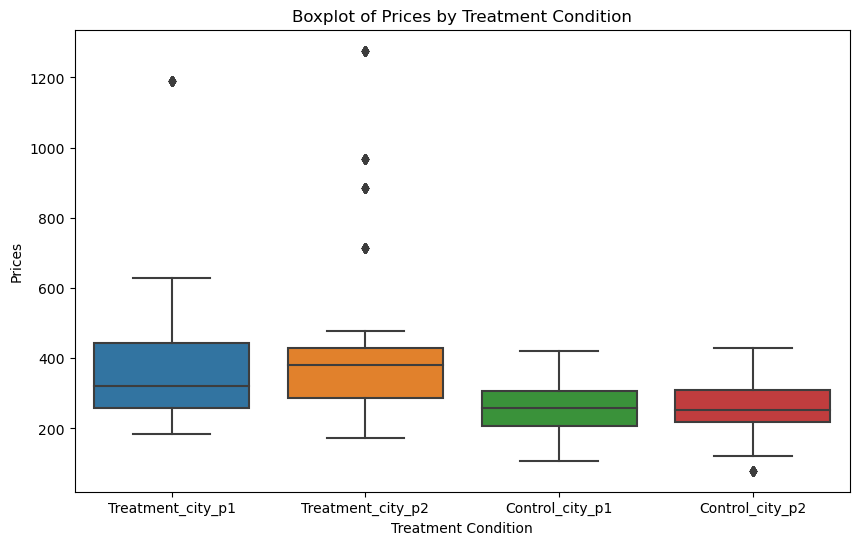

In [41]:
# Create a boxplot with conditional grouping
plt.figure(figsize=(10, 6))
sns.boxplot(data = df, x ='Treatment_city_and_treatment', y = 'Price')

# Add labels and title
plt.xlabel('Treatment Condition')
plt.ylabel('Prices')
plt.title('Boxplot of Prices by Treatment Condition')

# Show the plot
plt.show()

The plot shows that there is a difference in the distribution of data as the observed prices for the treatment city have a greater standard deviation compared to the values in the control city. It also highlights a difference in the average price in the treatment city in the two different periods which is not matched in the control city, showing that there might be a positive effect of treatment on the prices.

### Average Prices

In [42]:
average_prices = df.groupby('Treatment_city_and_treatment')['Price'].mean()
average_prices

Treatment_city_and_treatment
Control_city_p1      253.240000
Control_city_p2      258.440000
Treatment_city_p1    374.038462
Treatment_city_p2    437.423077
Name: Price, dtype: float64

### Regressions

#### Regression based on city

In [43]:
# Regression with only "treatment period" dummy
X1 = sm.add_constant(df['Treatment_city'])
model1 = sm.OLS(df['Price'], X1)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     499.1
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          7.62e-103
Time:                        15:49:17   Log-Likelihood:                -21196.
No. Observations:                3200   AIC:                         4.240e+04
Df Residuals:                    3198   BIC:                         4.241e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            256.1520      5.153     49.

#### Regression based on treatment period

In [44]:
# Regression with only "treatment period" dummy
X2 = sm.add_constant(df['Treatment_period'])
model2 = sm.OLS(df['Price'], X2)
results2 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     499.1
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          7.62e-103
Time:                        15:49:17   Log-Likelihood:                -21196.
No. Observations:                3200   AIC:                         4.240e+04
Df Residuals:                    3198   BIC:                         4.241e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            256.1520      5.153     49.

#### Regression Based on city and Treatment Period

In [45]:
# Regression with both "treatment period" and "treatment city" dummies and their interaction
df['Interaction_term'] = df['Treatment_period'] * df['Treatment_city']
X3 = sm.add_constant(df[['Treatment_period', 'Treatment_city', 'Interaction_term']])
model3 = sm.OLS(df['Price'], X3)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     189.4
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          4.83e-113
Time:                        15:49:17   Log-Likelihood:                -21166.
No. Observations:                3200   AIC:                         4.234e+04
Df Residuals:                    3196   BIC:                         4.236e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              253.2400      7.699  

### Explanation

The coefficient 'Interaction Term' represents the difference-in-differences (DiD) estimate. 
It captures the differential effect of the treatment on prices by considering the interaction between "treatment period" and "treatment city." The DiD method helps control for time-invariant factors and isolates the impact of the treatment by comparing the changes in the treatment city to the changes in the control city over time.

The need for a second city (control city) is crucial in DiD analysis to create a counterfactual. The control city allows us to account for trends or factors affecting both the treatment and control groups similarly. The interaction term (Treatment_period × Treatment_city) captures the differential effect by considering how the treatment effect varies across the treatment and control groups.

Since the results show that there is a high, positive and significant coefficient this shows that there is a substantially positive effect of treatment on prices.

## NLP - Analyzing Descriptions

### Utils

In [46]:
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [47]:
df.shape

(3200, 10)

In [48]:
df = df.dropna()

### Preprocessing:
- Removing special characters and numbers.
- Converting words to lowercase.
- Removing stopwords.
- Applying stemming.

In [69]:
text_column = 'Descriptions'

# Remove special characters and numbers
# df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# OR (if you want to keep numbers)
df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'\W', ' ', x))

# Convert each word using abbr_or_lower function
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))

# Remove stopwords
stop_words = set(stopwords.words('spanish'))
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

print(df['processed_text'])

0       mayerl bisb urquinaona ofrec wifi gratuita pre...
1       hotel diseño vista playa barceloneta centro ba...
2       pensión encuentra detrá plaza sant jaum barrio...
3       hotel encantador situado poco minuto pie rambl...
4       h rega adult onli ofrec habitacion air acondic...
                              ...                        
3183    hotel goza ubicación idónea junto ciudad art c...
3184    sorolla palac ofrec alojamiento elegant ubicad...
3185    hotel diseño ilunion aqua 3 situado valencia s...
3186    hotel turia encuentra junto estación autobus v...
3187    one shot colón 46 ubicado 10 minuto pie catedr...
Name: processed_text, Length: 3188, dtype: object


### Creating a document-term matrix (DTM)

In [67]:
# Create document term matrix using CountVectorizer

pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.05, max_df=0.30)
X = vectorizer.fit_transform(df['processed_text'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(dtm_df)
dtm_df.shape

,00,10,10 minuto,12,14,14 km,15,15 minuto,20,20 minuto,200,200 metro,22,30,300,300 metro,400,400 metro,50,50 metro,500,500 metro,600,600 metro,abierta,abierta 24,acondicionado calefacción,acondicionado cocina,acondicionado suelo,acondicionado tv,acondicionado wifi,aeropuerto barcelona,aeropuerto cercano,aeropuerto valencia,agua,air libr,alberga,alberga restaurant,alojamiento air,alojamiento alojamiento,alojamiento ofrec,alojamiento punto,alojamiento situado,alquil,alquil bicicleta,alquil coch,alrededor,amplia,antiguo,aparcamiento,aparcamiento privado,apart,apartamento,aperitivo,arena,armario,art ciencia,art santuaria,artículo,artículo aseo,aseo,aseo gratuito,asimismo,autobus,autobú,avenida,avenida diagon,bajo,bajo petición,balcón,bar,barcelona hotel,barcelona prat,barceloné,bare,bare restaurant,barrio,barrio gótico,basílica,basílica virgen,batlló,bañera,bañera hidromasaj,baño compartido,bebida,bebida aperitivo,bella,bicicleta,bien,bien comunicado,buffet,cada,cada habitación,cafetera,cafetería,café,calefacción,call,cama,cama toalla,carta,casa,casa batlló,casco,casco antiguo,catalonia,catalunya,cataluña,catedr,catedr barcelona,central,centro barcelona,centro ciudad,centro comerci,centro fit,cerca,cerca alojamiento,cercana,cercano,cercano aeropuerto,cerámica,cerámica art,chromecast,church,church of,ciencia,ciudad art,coch,cocina compartida,cocina mediterránea,cocina totalment,color,comedor,comerci,compartida,compartido,comunica,comunicado,común,conexion,conexión,conexión wi,conexión wifi,consigna,consigna equipaj,cuentan,cálido,decoración,decoración moderna,decoración sencilla,desamparado,desayuno,desayuno buffet,diagon,diario,directo,diseño,dispon,disponen air,disponen baño,distancia,distancia pie,ducha,ducha artículo,ducha secador,día,edificio,elegant,encuentra barcelona,encuentra km,encuentra minuto,encuentran,enlac,equipada air,equipado,equipaj,escritorio,especial,establecimiento alberga,establecimiento halla,establecimiento ofrec,estación tren,estilo,estrella,estrella ofrec,expendedora,exterior,facilita,familia,familia gaudí,famosa,fi,fi gratuita,fit,fogon,frent,fuert minibar,fuert tv,funcional,gaudí,gimnasio,gimnasio piscina,gonzález,gonzález martí,goza,goza ubicación,gracia,gran,grati,grati alojamiento,gratuita caja,gratuita habitacion,gratuita toda,gratuita tv,gratuito,gratuito secador,gótico,habitacion air,habitacion disponen,habitacion hotel,habitacion incluyen,habitacion moderna,habitacion recepción,habitación,halla,hervidor,hervidor agua,hidromasaj,hora servicio,horno,hospit,hostal,hotel encuentra,hotel estrella,hotel ofrec,hotel situado,huésped,ideal,impresionant,impresionant ciudad,incluy,incluyen air,incluyen escritorio,incluyen tv,información,información turística,inmediacion,insonorizada,instalacion,interé,jardin,jardin monfort,jardín,jardín turia,junto,km aeropuerto,km alojamiento,lavadora,lavavajilla,libr,lleva,lugar,lugar interé,luminosa,madera,malvarrosa,martí,mañana,mediterránea,meno,meno km,menú,mercado,metro estación,metro hospit,metro hotel,metro parada,metro plaza,microonda,microonda cafetera,mientra,min,min pie,minibar,minibar caja,minuto coch,minuto metro,moderna,moderno,monfort,monumento,mostrador,mostrador información,museo,museo nacion,máquina,máquina expendedora,mármol,nacion,nacion cerámica,nevera,nicolá,nort,nou,numerosa,numerosa tienda,numeroso,numeroso bare,obra,of,of saint,ofrec alojamiento,ofrec apartamento,ofrec servicio,ofrec wifi,ofrecen,parada,parada autobú,park,park privado,parqu,part,paseo,paseo gracia,pedrera,pelo artículo,pequeña,person,persona,petición,pie estación,pie paseo,pie plaza,piscina,piscina air,plana baño,plato,plato cocina,playa,playa malvarrosa,plaza catalunya,plaza cataluña,poca,poca distancia,poco,prat,presenta,presentan,presentan decoración,presta,presta servicio,privado ducha,privado secador,proporciona,pued,pueden,puerto,punto,punto interé,público,queda,rambla,rambla barcelona,restaurant bare,ropa,ropa cama,sagrada,sagrada familia,saint,saint nicolá,sala,salón,sant,s

(3188, 422)

### Percentage of presence of chosen word

In [51]:
chosen_word = 'desayuno'
print(f"Percentage of presence of the chose word: {round((dtm_df[chosen_word].sum()/dtm_df.shape[0]),3)*100}%")

Percentage of presence of the chose word: 32.2%


#### Word Cloud



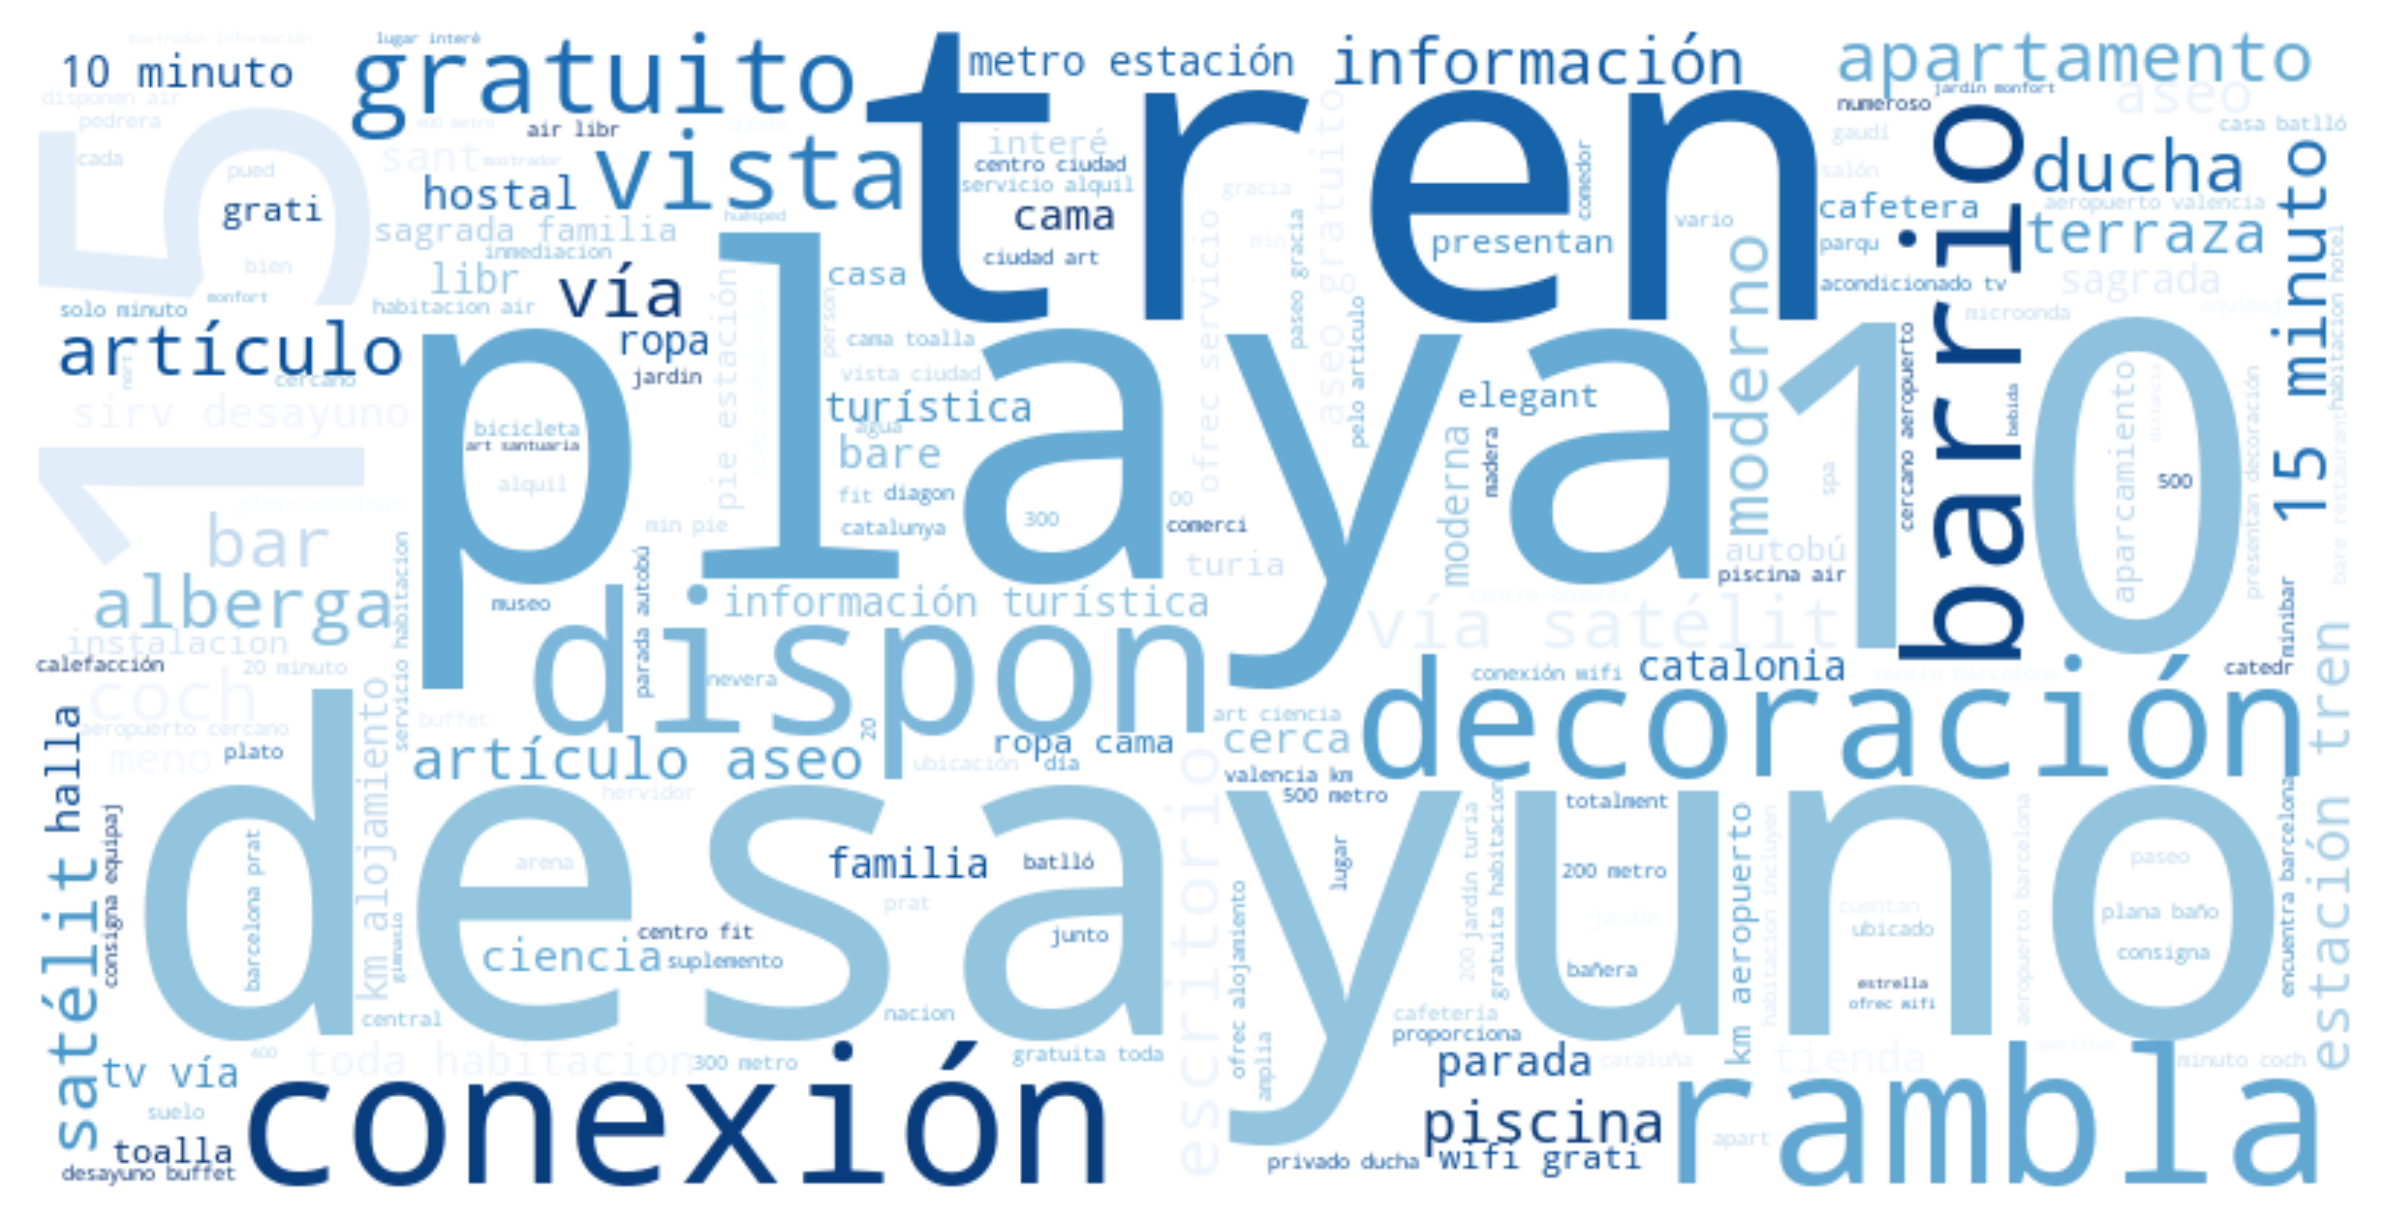

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a high-resolution word cloud object with relative scaling
wordcloud = WordCloud(
    background_color='white', 
    colormap='Blues', 
    width=800, 
    height=400,
    relative_scaling= 0  # Adjust the relative scaling value as desired
).generate_from_frequencies(dtm_df.sum())

# Plot the word cloud with a higher resolution
plt.figure(figsize=(10, 6), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Creating Term Frequency (TF)-Inverse Document Frequency (IDF) and text_length features 

In [53]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.30)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert TF-IDF to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Reset index of the original DataFrame to avoid duplicate indices
df = df.reset_index(drop=True)

# Add length feature
tfidf_df['text_length'] = df['processed_text'].apply(len)

# Concatenate the TF-IDF features and length with your original DataFrame
final_df = pd.concat([df, tfidf_df], axis=1)

# Display the final DataFrame
display(final_df)


,Unnamed: 0,Hotels,Ratings,Price,Link,Descriptions,Treatment_period,Treatment_city,Treatment_city_and_treatment,Interaction_term,processed_text,00,10,10 minuto,12,14,14 km,15,15 minuto,20,20 minuto,200,200 metro,22,30,300,300 metro,400,400 metro,50,50 metro,500,500 metro,600,600 metro,abierta,abierta 24,acondicionado calefacción,acondicionado cocina,acondicionado suelo,acondicionado tv,acondicionado wifi,aeropuerto barcelona,aeropuerto cercano,aeropuerto valencia,agua,air libr,alberga,alberga restaurant,alojamiento air,alojamiento alojamiento,alojamiento ofrec,alojamiento punto,alojamiento situado,alquil,alquil bicicleta,alquil coch,alrededor,amplia,antiguo,aparcamiento,aparcamiento privado,apart,apartamento,aperitivo,arena,armario,art ciencia,art santuaria,artículo,artículo aseo,aseo,aseo gratuito,asimismo,autobus,autobú,avenida,avenida diagon,bajo,bajo petición,balcón,bar,barcelona hotel,barcelona prat,barceloné,bare,bare restaurant,barrio,barrio gótico,basílica,basílica virgen,batlló,bañera,bañera hidromasaj,baño compartido,bebida,bebida aperitivo,bella,bicicleta,bien,bien comunicado,buffet,cada,cada habitación,cafetera,cafetería,café,calefacción,call,cama,cama toalla,carta,casa,casa batlló,casco,casco antiguo,catalonia,catalunya,cataluña,catedr,catedr barcelona,central,centro barcelona,centro ciudad,centro comerci,centro fit,cerca,cerca alojamiento,cercana,cercano,cercano aeropuerto,cerámica,cerámica art,chromecast,church,church of,ciencia,ciudad art,coch,cocina compartida,cocina mediterránea,cocina totalment,color,comedor,comerci,compartida,compartido,comunica,comunicado,común,conexion,conexión,conexión wi,conexión wifi,consigna,consigna equipaj,cuentan,cálido,decoración,decoración moderna,decoración sencilla,desamparado,desayuno,desayuno buffet,diagon,diario,directo,diseño,dispon,disponen air,disponen baño,distancia,distancia pie,ducha,ducha artículo,ducha secador,día,edificio,elegant,encuentra barcelona,encuentra km,encuentra minuto,encuentran,enlac,equipada air,equipado,equipaj,escritorio,especial,establecimiento alberga,establecimiento halla,establecimiento ofrec,estación tren,estilo,estrella,estrella ofrec,expendedora,exterior,facilita,familia,familia gaudí,famosa,fi,fi gratuita,fit,fogon,frent,fuert minibar,fuert tv,funcional,gaudí,gimnasio,gimnasio piscina,gonzález,gonzález martí,goza,goza ubicación,gracia,gran,grati,grati alojamiento,gratuita caja,gratuita habitacion,gratuita toda,gratuita tv,gratuito,gratuito secador,gótico,habitacion air,habitacion disponen,habitacion hotel,habitacion incluyen,habitacion moderna,habitacion recepción,habitación,halla,hervidor,hervidor agua,hidromasaj,hora servicio,horno,hospit,hostal,hotel encuentra,hotel estrella,hotel ofrec,hotel situado,huésped,ideal,impresionant,impresionant ciudad,incluy,incluyen air,incluyen escritorio,incluyen tv,información,información turística,inmediacion,insonorizada,instalacion,interé,jardin,jardin monfort,jardín,jardín turia,junto,km aeropuerto,km alojamiento,lavadora,lavavajilla,libr,lleva,lugar,lugar interé,luminosa,madera,malvarrosa,martí,mañana,mediterránea,meno,meno km,menú,mercado,metro estación,metro hospit,metro hotel,metro parada,metro plaza,microonda,microonda cafetera,mientra,min,min pie,minibar,minibar caja,minuto coch,minuto metro,moderna,moderno,monfort,monumento,mostrador,mostrador información,museo,museo nacion,máquina,máquina expendedora,mármol,nacion,nacion cerámica,nevera,nicolá,nort,nou,numerosa,numerosa tienda,numeroso,numeroso bare,obra,of,of saint,ofrec alojamiento,ofrec apartamento,ofrec servicio,ofrec wifi,ofrecen,parada,parada autobú,park,park privado,parqu,part,paseo,paseo gracia,pedrera,pelo artículo,pequeña,person,persona,petición,pie estación,pie paseo,pie plaza,piscina,piscina air,plana baño,plato,plato cocina,playa,playa malvarrosa,plaza catalunya,plaza cataluña,poca,poca distancia,poco,prat,presenta,presentan,presentan decoración,presta,presta servicio,privado ducha,privado secador,proporciona,pued,pueden,puerto,punto

### Show top words

In [54]:
from nltk.corpus import stopwords

# Assuming 'Descriptions' is the column containing text descriptions
corpus = df['Descriptions']

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords.words("spanish"))
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray()

# Create a DataFrame to display the top words and their TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_scores, columns=feature_names)

# Display the top words and their TF-IDF scores
top_words = tfidf_df.sum(axis=0).sort_values(ascending=False)
print(top_words)


km             223.598490
hotel          221.109988
alojamiento    197.784737
valencia       192.577596
barcelona      188.507891
                  ...    
sky              4.188302
repleta          4.188302
hetero           4.188302
rocafort         4.188302
gayxample        4.188302
Length: 1000, dtype: float64


### Sentiment Analysis

In [55]:
# Assuming 'Descriptions' is the column containing text descriptions
final_df['sentiment'] = final_df['Descriptions'].apply(lambda x: TextBlob(x).sentiment.polarity)
final_df

,Unnamed: 0,Hotels,Ratings,Price,Link,Descriptions,Treatment_period,Treatment_city,Treatment_city_and_treatment,Interaction_term,processed_text,00,10,10 minuto,12,14,14 km,15,15 minuto,20,20 minuto,200,200 metro,22,30,300,300 metro,400,400 metro,50,50 metro,500,500 metro,600,600 metro,abierta,abierta 24,acondicionado calefacción,acondicionado cocina,acondicionado suelo,acondicionado tv,acondicionado wifi,aeropuerto barcelona,aeropuerto cercano,aeropuerto valencia,agua,air libr,alberga,alberga restaurant,alojamiento air,alojamiento alojamiento,alojamiento ofrec,alojamiento punto,alojamiento situado,alquil,alquil bicicleta,alquil coch,alrededor,amplia,antiguo,aparcamiento,aparcamiento privado,apart,apartamento,aperitivo,arena,armario,art ciencia,art santuaria,artículo,artículo aseo,aseo,aseo gratuito,asimismo,autobus,autobú,avenida,avenida diagon,bajo,bajo petición,balcón,bar,barcelona hotel,barcelona prat,barceloné,bare,bare restaurant,barrio,barrio gótico,basílica,basílica virgen,batlló,bañera,bañera hidromasaj,baño compartido,bebida,bebida aperitivo,bella,bicicleta,bien,bien comunicado,buffet,cada,cada habitación,cafetera,cafetería,café,calefacción,call,cama,cama toalla,carta,casa,casa batlló,casco,casco antiguo,catalonia,catalunya,cataluña,catedr,catedr barcelona,central,centro barcelona,centro ciudad,centro comerci,centro fit,cerca,cerca alojamiento,cercana,cercano,cercano aeropuerto,cerámica,cerámica art,chromecast,church,church of,ciencia,ciudad art,coch,cocina compartida,cocina mediterránea,cocina totalment,color,comedor,comerci,compartida,compartido,comunica,comunicado,común,conexion,conexión,conexión wi,conexión wifi,consigna,consigna equipaj,cuentan,cálido,decoración,decoración moderna,decoración sencilla,desamparado,desayuno,desayuno buffet,diagon,diario,directo,diseño,dispon,disponen air,disponen baño,distancia,distancia pie,ducha,ducha artículo,ducha secador,día,edificio,elegant,encuentra barcelona,encuentra km,encuentra minuto,encuentran,enlac,equipada air,equipado,equipaj,escritorio,especial,establecimiento alberga,establecimiento halla,establecimiento ofrec,estación tren,estilo,estrella,estrella ofrec,expendedora,exterior,facilita,familia,familia gaudí,famosa,fi,fi gratuita,fit,fogon,frent,fuert minibar,fuert tv,funcional,gaudí,gimnasio,gimnasio piscina,gonzález,gonzález martí,goza,goza ubicación,gracia,gran,grati,grati alojamiento,gratuita caja,gratuita habitacion,gratuita toda,gratuita tv,gratuito,gratuito secador,gótico,habitacion air,habitacion disponen,habitacion hotel,habitacion incluyen,habitacion moderna,habitacion recepción,habitación,halla,hervidor,hervidor agua,hidromasaj,hora servicio,horno,hospit,hostal,hotel encuentra,hotel estrella,hotel ofrec,hotel situado,huésped,ideal,impresionant,impresionant ciudad,incluy,incluyen air,incluyen escritorio,incluyen tv,información,información turística,inmediacion,insonorizada,instalacion,interé,jardin,jardin monfort,jardín,jardín turia,junto,km aeropuerto,km alojamiento,lavadora,lavavajilla,libr,lleva,lugar,lugar interé,luminosa,madera,malvarrosa,martí,mañana,mediterránea,meno,meno km,menú,mercado,metro estación,metro hospit,metro hotel,metro parada,metro plaza,microonda,microonda cafetera,mientra,min,min pie,minibar,minibar caja,minuto coch,minuto metro,moderna,moderno,monfort,monumento,mostrador,mostrador información,museo,museo nacion,máquina,máquina expendedora,mármol,nacion,nacion cerámica,nevera,nicolá,nort,nou,numerosa,numerosa tienda,numeroso,numeroso bare,obra,of,of saint,ofrec alojamiento,ofrec apartamento,ofrec servicio,ofrec wifi,ofrecen,parada,parada autobú,park,park privado,parqu,part,paseo,paseo gracia,pedrera,pelo artículo,pequeña,person,persona,petición,pie estación,pie paseo,pie plaza,piscina,piscina air,plana baño,plato,plato cocina,playa,playa malvarrosa,plaza catalunya,plaza cataluña,poca,poca distancia,poco,prat,presenta,presentan,presentan decoración,presta,presta servicio,privado ducha,privado secador,proporciona,pued,pueden,puerto,punto

### Ideas for NLP:
- Including Keyword presence (words related to Sonar Festival)
- Word Embeddings (Optional)


## Final Regression

### Adding NLP Features

In [63]:
# Regression with both "treatment period" and "treatment city" dummies and their interaction
final_df['Interaction_term'] = final_df['Treatment_period'] * final_df['Treatment_city']
X4 = sm.add_constant(final_df[['Treatment_period', 'Treatment_city', 'Interaction_term', 'desayuno', 'playa', 'balcón', 'acondicionado wifi', 'bañera hidromasaj','dispon','desayuno','aseo','decoración','km']])
model4 = sm.OLS(final_df['Price'], X4)
results4 = model4.fit()
print(results4.summary())

KeyError: "['km'] not in index"